<a href="https://colab.research.google.com/github/rukshar69/ML-fashion-mnist-GAN/blob/main/fashion_mnist_GAN_continuous_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Optional: move to the desired location:
#%cd drive/My Drive/DIRECTORY_IN_YOUR_DRIVE

Mounted at /content/drive


In [ ]:
# Bringing in tensorflow
import tensorflow as tf
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
# Do some data transformation
import numpy as np


In [ ]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255



In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64) #prefetch 64 elements (64 batches, of 128 examples each).


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2QZ5FR/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2QZ5FR/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# Build Neural Network

## Import Modelling Components

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## Build Generator

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

## Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model



# Training Loop

## Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt =  tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # lr for generator is greater than the lr for discriminator because we want our generator to learn faster than discriminator
d_opt =  tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model


In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs so that discriminator becomes a bit confused and prevent its power to detect fake images from taking
            # over the generator's ability to create convincing fake images
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
#load generator and discriminator model weights
generator = build_generator()
discriminator = build_discriminator()
# Load generator and discriminator weights from the previous run to start training from where it was left off.
generator.load_weights('drive/My Drive/personal_projects/fashion_gan/model/latest_generator.h5')
discriminator.load_weights('drive/My Drive/personal_projects/fashion_gan/model/latest_discriminator.h5')

# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=2, latent_dim=128):
      self.num_img = num_img
      self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
      self.model.generator.save('drive/My Drive/personal_projects/fashion_gan/model/latest_generator.h5')
      self.model.discriminator.save('drive/My Drive/personal_projects/fashion_gan/model/latest_discriminator.h5')

      random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
      generated_images = self.model.generator(random_latent_vectors)
      generated_images *= 255
      generated_images.numpy()
      for i in range(self.num_img):
          img = array_to_img(generated_images[i])
          img.save(os.path.join('drive/My Drive/personal_projects/fashion_gan/images', f'generated_img_{epoch}_{i}.png'))
      # keys = list(logs.keys())
      # print("End epoch {} of training; got log keys: {}".format(epoch, keys))
      # Open the losses.txt file in append mode
      with open('drive/My Drive/personal_projects/fashion_gan/losses.txt', 'a') as file:
          # Append the values of 'd_loss' and 'g_loss' to the file
          file.write(f'{logs["d_loss"]},{logs["g_loss"]}\n')



## Train & Review Performance

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=40, callbacks=[ModelMonitor()])
#hist = fashgan.fit(ds, epochs=20, )

Epoch 1/40
  6/469 [..............................] - ETA: 1:10 - d_loss: 0.2623 - g_loss: 2.8039

469/469 [==============================] - ETA: 0s - d_loss: 0.2675 - g_loss: 2.7910

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 88s 161ms/step - d_loss: 0.2674 - g_loss: 2.7911
Epoch 2/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7887

469/469 [==============================] - 79s 168ms/step - d_loss: 0.2670 - g_loss: 2.7885
Epoch 3/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2675 - g_loss: 2.7781

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2675 - g_loss: 2.7781
Epoch 4/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2673 - g_loss: 2.7706

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2673 - g_loss: 2.7706
Epoch 5/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7799

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2667 - g_loss: 2.7798
Epoch 6/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2671 - g_loss: 2.7701

469/469 [==============================] - 80s 171ms/step - d_loss: 0.2671 - g_loss: 2.7700
Epoch 7/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7766

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2667 - g_loss: 2.7766
Epoch 8/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2665 - g_loss: 2.7697

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2664 - g_loss: 2.7698
Epoch 9/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7650

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2670 - g_loss: 2.7650
Epoch 10/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2671 - g_loss: 2.7603

469/469 [==============================] - 81s 172ms/step - d_loss: 0.2671 - g_loss: 2.7603
Epoch 11/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7513

469/469 [==============================] - 80s 171ms/step - d_loss: 0.2668 - g_loss: 2.7512
Epoch 12/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2666 - g_loss: 2.7526

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2666 - g_loss: 2.7526
Epoch 13/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7508

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2668 - g_loss: 2.7508
Epoch 14/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7440

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2670 - g_loss: 2.7440
Epoch 15/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2672 - g_loss: 2.7484

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2672 - g_loss: 2.7485
Epoch 16/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2664 - g_loss: 2.7506

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2664 - g_loss: 2.7505
Epoch 17/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7506

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2670 - g_loss: 2.7505
Epoch 18/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7509

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2667 - g_loss: 2.7509
Epoch 19/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7450

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2668 - g_loss: 2.7450
Epoch 20/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7350

469/469 [==============================] - 80s 171ms/step - d_loss: 0.2670 - g_loss: 2.7349
Epoch 21/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2664 - g_loss: 2.7399

469/469 [==============================] - 80s 171ms/step - d_loss: 0.2664 - g_loss: 2.7399
Epoch 22/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2669 - g_loss: 2.7345

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2669 - g_loss: 2.7344
Epoch 23/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7319

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2667 - g_loss: 2.7319
Epoch 24/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7293

469/469 [==============================] - 80s 171ms/step - d_loss: 0.2667 - g_loss: 2.7293
Epoch 25/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2672 - g_loss: 2.7321

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2672 - g_loss: 2.7323
Epoch 26/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2672 - g_loss: 2.7278

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2672 - g_loss: 2.7279
Epoch 27/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2661 - g_loss: 2.7336

469/469 [==============================] - 79s 169ms/step - d_loss: 0.2661 - g_loss: 2.7336
Epoch 28/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2671 - g_loss: 2.7321

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2670 - g_loss: 2.7321
Epoch 29/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7293

469/469 [==============================] - 79s 169ms/step - d_loss: 0.2668 - g_loss: 2.7292
Epoch 30/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2673 - g_loss: 2.7326

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2673 - g_loss: 2.7326
Epoch 31/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2667 - g_loss: 2.7322

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2667 - g_loss: 2.7323
Epoch 32/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7287

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2668 - g_loss: 2.7287
Epoch 33/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7363

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2668 - g_loss: 2.7363
Epoch 34/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2666 - g_loss: 2.7338

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2666 - g_loss: 2.7338
Epoch 35/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2668 - g_loss: 2.7307

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2668 - g_loss: 2.7307
Epoch 36/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2670 - g_loss: 2.7281

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2670 - g_loss: 2.7281
Epoch 37/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2666 - g_loss: 2.7288

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2666 - g_loss: 2.7287
Epoch 38/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2672 - g_loss: 2.7189

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2672 - g_loss: 2.7188
Epoch 39/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2666 - g_loss: 2.7190

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2666 - g_loss: 2.7191
Epoch 40/40
469/469 [==============================] - ETA: 0s - d_loss: 0.2671 - g_loss: 2.7226

469/469 [==============================] - 80s 170ms/step - d_loss: 0.2671 - g_loss: 2.7226


# Review Loss

       d_loss    g_loss
0    0.351713  1.227654
1    0.290682  6.515552
2    0.283210  6.651370
3    0.668037  0.659459
4    0.743471  0.558146
..        ...       ...
609  0.265047  2.694426
610  0.273990  2.710618
611  0.269421  2.696149
612  0.253567  2.748521
613  0.272311  2.713592

[614 rows x 2 columns]


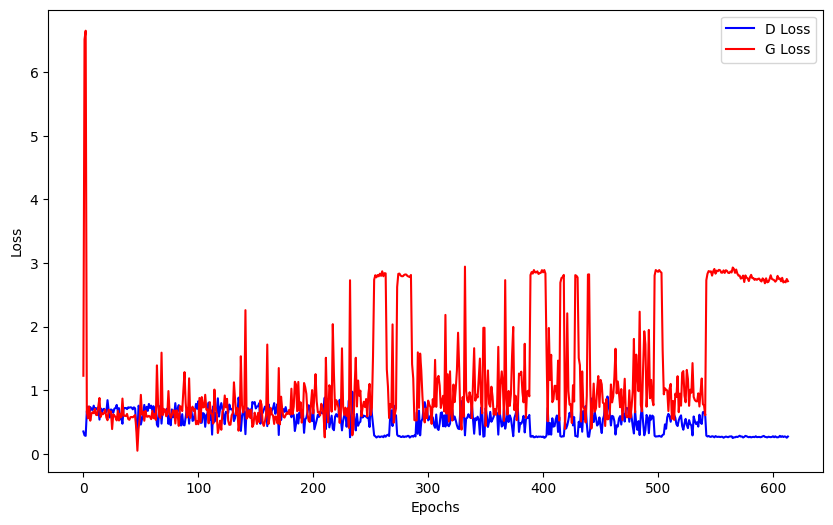

In [ ]:
import pandas as pd
# Assuming your text file is named 'losses.txt'
file_path = 'drive/My Drive/personal_projects/fashion_gan/losses.txt'

# Read the text file into a DataFrame
df = pd.read_csv(file_path, names=['d_loss', 'g_loss'], header=None, delimiter=',')

# If you want to skip the first row (header), you can add skiprows=1:
# df = pd.read_csv(file_path, names=['d_loss', 'g_loss'], header=None, delimiter=',', skiprows=1)

# Display the DataFrame
print(df)
# Plot 'd_loss' and 'g_loss' columns
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Access the columns and plot them
plt.plot(df['d_loss'], label='D Loss', color='blue')
plt.plot(df['g_loss'], label='G Loss', color='red')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()